# Introduction

A commonly seen phenomenon when working on continuous regression problems is the residual variance not being constant, also known as [heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity). While heteroscedasticity has been frequently treated in Statistics and Econometrics literature, it doesn't - in my opinion - receive as much attention in mainstream Machine Learning and Data Science publications. While predicting the mean via MSE-minimization is often sufficient and more pragmatic, I believe that properly addressing variance issues might be necessary sometimes, see for example this [past blogpost of mine](https://numbersandcode.com/why-probability-and-uncertainty-should-be-an-integral-part-of-regression-models-part1).

In this article I want to show an example of how Gaussian Process regression can be used to model heteroscedastic data. Since explaining every theoretical aspect would go far beyond the scope of this post, I highly recommend reading the references if you are interested in such models. First, let us start with a brief problem definition.

# Problem definition

At the heart of non-constant variance models lies the assumption of some functional relation between the input data and the variance of the target variable. Presuming, in addition, Gaussian distributed target variable, we have the following situation:

$$y\sim\mathcal{N}\left(m(X),\sigma^2(X)\right)$$

Put plainly, for input data, the corresponding target should be Gaussian with mean and variance being an arbitrary function of our inputs. Since our focus today is on the variance, let us simplify things a little with a zero-mean function, i.e.

$$y\sim\mathcal{N}\left(0,\sigma^2(X)\right)$$

Our task is now to find a suitable function for sigma squared.

Provided that, ex-ante, we don't know much about our target function, whatever model we come up should ideally account for our uncertainty about the actual functional form of the data generating process. This is also known as [epistemic uncertainty](http://www.ce.memphis.edu/7137/PDFs/Abrahamson/C05.pdf) and quite elegantly considered in [Bayesian Machine Learning](https://algorithmia.com/blog/bayesian-machine-learning). In simple terms, we now don't expect that a single model would best describe our target function anymore. Instead, a - possibly infinitely large - set of models is now considered and our goal is to place a probability distribution (a.k.a. posterior distribution) on this set such that models that best describe the data (a.k.a. likelihood) given the assumptions we made (a.k.a. prior distributions) are the most likely ones.

This is commonly done in weight space by describing our set of models by the sets of parameters that describe the model's behavior - probably the most famous example in Machine Learning are [Bayesian Neural Networks](https://medium.com/neuralspace/bayesian-neural-network-series-post-1-need-for-bayesian-networks-e209e66b70b2). Another, slightly more abstract, approach is to directly work in function space, i.e. we now explicitly look for the most likely functions without requiring parameters to describe them in the first place. Being in the Bayesian domain, this also means that prior and posterior distributions are now not put over parameters anymore but also directly over functions. Probably the most iconic framework for such modeling is [Gaussian Process (GP) regression](https://distill.pub/2019/visual-exploration-gaussian-processes/).

If this is a new concept to you and sounds confusing, I recommend to not worry about the underlying assumptions for now and just look at the formulas. One of the - by number of citations - most popular books on Gaussian Process models, [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/) (GPML) provides a relatively clear introduction to the theoretical setup and is completely open source. In order to not bloat this article too much, I will not go describe each step too deeply and rather suggest you study the topics you don't understand yourself.

# The model

Our goal will be to model the varying variance of the target variable through a GP, this looks as follows:


$$y\sim \mathcal{N}(0,f^{exp}(X))$$

$$f(\cdot)\sim \mathcal{GP}(0,k(\cdot,\cdot)+\nu\cdot\delta_{ij}),\,f^{exp}(X)=exp(f(X))$$

This implies that the logarithm of our variance function is a GP - we need to squash the raw GP through an exponential in order to ensure that the variance will always be greater than zero. We can additonally conclude that the GP is actually a latent component of our model that we never observe directly but is only implicitly visible from the data we collect. Finally, we presumed additional noise on the GP kernel which makes the model more stable in practice. 

The posterior distribution can then be derived via Bayes' theorem as follows:

$$p(f|X,y)=\frac{\mathcal{N}(y|0,f^{exp}(X))\cdot\mathcal{GP}(f|0,k(\cdot,\cdot)+\nu^2\cdot\delta_{ij}))}{p(y|X)}$$

While it is possible to analytically derive the left-hand side in some basic GP models, we cannot do so in our case. Instead we will use a [Laplace Approximation](https://cedar.buffalo.edu/~srihari/CSE574/Chap4/4.4-Laplace.pdf) and approximate it through a synthetic multivariate Normal:

$$p(f|X,y)\approx \mathcal{N}(f|\hat{f},A)$$

The exact steps for Laplace Approximation are described quite thoroughly in [Chapter 3 of the GPML book](http://www.gaussianprocess.org/gpml/chapters/RW3.pdf) and we only need to adjust the approach to our model.

In summary, the mean parameter of our approximation should match the mode of the posterior, while its covariance matrix is the negative inverse of the Hessian matrix of our data log-likelihood function. Formally, we have:

$$\hat{f}=argmax_f \log\mathcal{N}(y|0,f^{exp}(X))+\log\mathcal{GP}(f|0,k(\cdot,\cdot)+\nu^2\cdot\delta_{ij}))$$

$$A^{-1}=-\nabla^2 \log \mathcal{N}(y|0,f^{exp}(X))$$

The first equation is derived from the fact that the denominator of the posterior does not depend on our target and by the monotonicity of the logarithm function. The latter eqation is derived from a second-order Taylor-expansion around the maximum of the posterior function. 

In order to calculate the mean for some example data later on, we will simply plug in the whole loss into an autodiff package and let the computer do the rest. For the covariance of our approximation, we need to actually calculate the Hessian matrix. A common simplification for GP models is the assumption of independent observations of the target variable given a realization of the latent GP:

$$p(y|f)=\prod_{i=1}^N p(y_i|f)$$

This allows us to simplify the Hessian matrix to be zero everywhere, except for its diagonal being the second-order derivative of the log-likelihood function with respect to the GP:

$$H_{ii}=\frac{\partial^2}{\partial f_i^2}\log p(y_i|f_i)$$

The right-hand side can be derived by differentiating the standard Gaussian log-likelihood twice with respect to the variance while accounting for our exponential transform:

$$\frac{\partial^2}{\partial f_i^2}\log p(y_i|f_i)$$

$$=\frac{\partial}{\partial f_i} \frac{\partial}{\partial f_i}\log p(y_i|f_i)$$

$$=\frac{\partial}{\partial f_i} \frac{\partial}{\partial f_i}\left( -0.5 \log (2\pi)-0.5f_i - 0.5\frac{y_i^2}{exp(f_i)}\right)$$

$$=\frac{\partial}{\partial f_i} \left(-0.5 + 0.5\frac{y_i^2}{exp(f_i)}\right)$$

$$=- 0.5\frac{y_i^2}{exp(f_i)}$$

Which yields

$$H_{ii}=- 0.5\frac{y_i^2}{exp(f_i)}$$

and 

$$A_{ii}=2\cdot\frac{exp(f_i)}{y_i^2}$$


Finally, we need to derive the so-called posterior predictive distribution i.e. our predictions for new, unobserved inputs:

$$p(y^*|X^*,X,Y)$$

I will only state the results from [GPML, chapter 3] for our setup, without the necessary derivations. First, we need to calculate the posterior predictive distribution for the latent GP which, using our approximation from above, is yet another GP:

$$p(f^*|X^*,X,Y)=\mathcal{GP}(f^*|\mu^*,S^*)$$

$$\mu^*=K_{*N}K_{NN}^{-1}\hat{f}$$

$$S^*=K_{**}-K_{*N}(K_{NN}+A)^{-1}K_{*N}^T$$

where the K-variables denote the kernel covariance gram-matrices for training and evaluation dataset and the kernel cross-covariance matrix between training and evaluation datasets.
If you are farmiliar with GP-regression, you can see that the posterior mean and covariance terms are almost the same as in the standard case, except that we accounted for mean and covariance of our Laplace approximation.

Finally, we can derive the posterior predictive distribution for new data by marginalizing out the GP posterior predictive function:

$$p(y^*|X^*,X,Y)=\int p(y^*|f^*)p(f^*|\mu^*,S^*)df^* = \int\mathcal{N}(y^*|0,f^*)\mathcal{GP}(f^*|\mu^*,S^*)df^*$$

This integral is also intractable to solve analytically - luckily, since we only want to evaluate the posterior predictive distribution, we can approximate the target distribution via Monte Carlo sampling.

In order to demonstrate this approach in practice, I implemented a brief example in Julia. The full code can be found in a Jupyter notebook on [Github]().

## A quick example using Julia

The data is a fairly simple, 1D toy-example with 200 observations and generating distributions

$$y\sim \mathcal{N}(0,sin^2(2 *X)),\quad X\sim\mathcal{U}(-3,3)$$

i.e. the input variable is sampled uniformly between -3 and 3, while the target is drawn from a zero-mean Gaussian with periodic variance:

In [2]:
using Flux, Zygote, Distributions, DistributionsAD, FastGaussQuadrature, Plots, StatsPlots, KernelFunctions, LinearAlgebra, Random

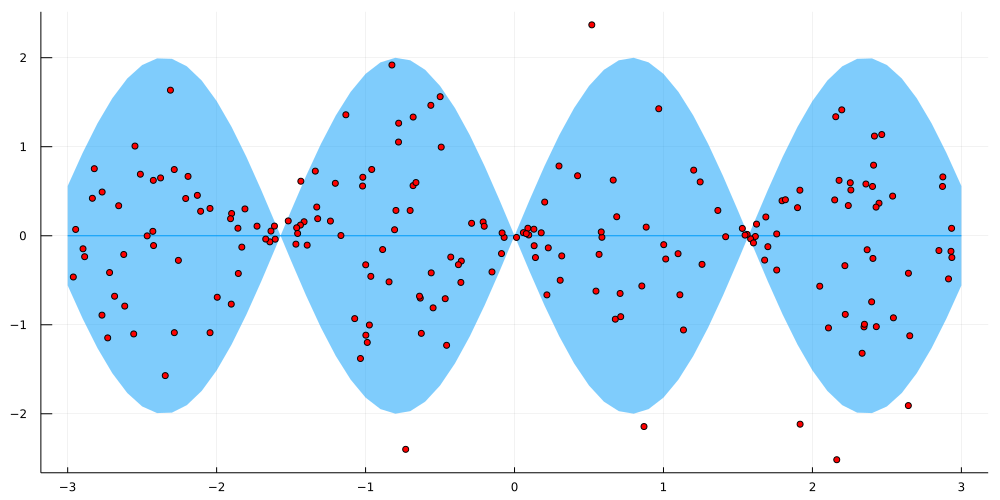

In [29]:
Random.seed!(987)

sample_size = 200

X = rand(1,sample_size).*6 .- 3
Xline = Matrix(transpose(collect(-3.9:0.1:3.9)[:,:])) #small, interpolated 1D grid for evalutaion
Xline_train = Xline[(Xline.>=-3) .& (Xline.<=3)]
y = randn(1,sample_size).*sin.(2 .*X)



plot(Xline_train,zeros(length(Xline_train));ribbon=(2 .* sin.(2 .*Xline_train)))
scatter!(X[:],y[:],legend=:none, fmt = :png,size=(1000,500),color=:red)


In order to fully define the GP, we also need to specify the kernel function - here I chose a standard Square-Exponential (SE) kernel plus additive noise term, i.e.

$$k(x,x') = s\cdot\exp\left(\frac{(x-x')^2}{l}\right) + \nu\delta_{xx'}$$

where all three hyperparameters need to be positive. We now have all the formulas we need in order to define the necessary functions and structs (Julia's functional counterpart to classes in object oriented languages)

In [30]:
mutable struct SEKernel <: KernelFunctions.Kernel
    l_log
    s_log


end

Flux.@functor SEKernel

SEKernel() = SEKernel(ones(1,1),ones(1,1))

#using KernelFunctions.jl for the primitives, we specify the raw SE-kernel here - the noise term will be added in the full model 
KernelFunctions.kernelmatrix(m::SEKernel,x::Matrix,y::Matrix) = exp.(m.s_log)[1,1].*exp.(
                                                                    -sum(exp.(m.l_log).*(Flux.unsqueeze(x,3).-Flux.unsqueeze(y,2)).^2,dims=1)[1,:,:]
                                                                )

KernelFunctions.kernelmatrix(m::SEKernel,x::Matrix) = KernelFunctions.kernelmatrix(m,x,x)




In [31]:
mutable struct HeteroscedasticityGPModel
    
    kern
    
    f_hat
    
    nu_log
    
end
Flux.@functor HeteroscedasticityGPModel


# 'n' specifies the dimensionality or our Laplace Approximation - needs to be equal to the size of the training dataset
HeteroscedasticityGPModel(n) = HeteroscedasticityGPModel(SEKernel(),zeros(1,n),ones(1,1))



# this is the log-likelihood term we need for calculating the optimal mean parameter of the Laplace Approximation - Zygote.jl and Flux.jl will be used for Autodiff 

function loss(m::HeteroscedasticityGPModel,y,X)
    _,N = size(m.f_hat)
    K= kernelmatrix(m.kern,X)
        
            
    likelihood_term = sum(llnormal.(y[:],zeros(N),m.f_hat[:]))
    prior_term = Distributions.logpdf(MvNormal(zeros(N),K.+Diagonal(ones(N).*exp.(m.nu_log)[1,1])),m.f_hat[:])
    
    return -likelihood_term - prior_term #negative since Flux.Optimise minimizes the target but we want to maximize it
end




loss (generic function with 1 method)

In [32]:
#Manual derivation of log-likelihood and hessian diagonal of the log-likelihood with respect to f; the gradient is also included 

llnormal(x,m,s) = -0.5 * log(2. * 3.14 * exp(s)) - 1 ./(2 .*exp(s))*(x-m)^2.
llnormgrad(x,m,s) = -0.5 + 0.5*1/exp(s)*(x-m)^2
llnormhess(x,m,s) = - 0.5/exp(s)*(x-m)^2


#finite differences test to ensure that the formulas for the gradient and hessian diagonal are correct
eps = 1e-10
@assert abs((llnormal(2,1,1)-llnormal(2,1,1-eps))/eps - llnormgrad(2,1,1)) < 1e-6
@assert abs((llnormgrad(2,1,1)-llnormgrad(2,1,1-eps))/eps - llnormhess(2,1,1)) <1e-6

In [33]:
model = HeteroscedasticityGPModel(sample_size)
params = Flux.params(model)


Params([[1.0], [1.0], [0.0 0.0 … 0.0 0.0], [1.0]])

In [34]:
#test that the Zygote.jl gradients are actually working
Zygote.gradient(()->loss(model,y,X),params)

Grads(...)

In [35]:
opt = ADAM(0.01)

for i in 1:2500
    
    grads = Zygote.gradient(()->loss(model,y,X),params)
    Flux.Optimise.update!(opt,params,grads)
    
    if i%250==0
        println(loss(model,y,X))
    end
end

257.7696064407182
23.566035832012545
-212.35518607476666
-443.23213144318044
-652.421062921603
-784.6409007673576
-876.3574589724197
-925.9732364323172
-942.2265319212983
-940.1639143185172


In [36]:
#calculate the posterior distribution of f evaluated at X_star

M,N = size(model.f_hat)

K= kernelmatrix(model.kern,hcat(X,Xline)).+Diagonal(exp(model.nu_log[1,1]).*ones(N+size(Xline)[2]))
A = inv(-Diagonal(llnormhess.(y[:],zeros(N),model.f_hat[:])).+Diagonal(ones(sample_size).*1e-6))


#kernel covariance matrices as 

K_NN = K[1:sample_size,1:sample_size]
K_star_star = K[sample_size+1:end,sample_size+1:end]
K_star_N = K[sample_size+1:end,1:sample_size]


#posterior mean and covariance of the GP evaluated at `Xline`
mu_star = model.f_hat*inv(K_NN.+Diagonal(ones(sample_size).*1e-6))*transpose(K_star_N)
S_star = K_star_star.- K_star_N*inv(K_NN.+inv(K_NN.+A .+ Diagonal(ones(sample_size).*1e-6)))*transpose(K_star_N)

#posterior probability distribution of f, evaluated at X_star
p_f_star = MvNormal(mu_star[:],Symmetric(S_star.+Diagonal(ones(size(Xline)[2]).*1e-6)))

FullNormal(
dim: 79
μ: [-2.1829310058325366, -2.455541573588052, -2.7004627519654134, -2.8943566962965384, -3.0136197832090383, -3.0374662571831585, -2.951360452647327, -2.7503189114714557, -2.4415148553027746, -2.0456112809579854  …  -1.9742112421782059, -2.27817036286057, -2.476765815305538, -2.5635893776159655, -2.544054574835686, -2.4327377133714716, -2.2501183753342695, -2.0192685694126475, -1.7629283564587166, -1.5012553390140821]
Σ: [10.236026937642114 8.752732275623323 … -0.03998264044680905 -0.04094856893601606; 8.752732275623323 7.5370203489287375 … -0.039661979690349194 -0.04069600483762004; … ; -0.03998264044680905 -0.039661979690349194 … 8.44815155433371 9.740312354900041; -0.04094856893601606 -0.04069600483762004 … 9.740312354900041 11.310466949498897]
)



The resulting functional posterior predictive distribution after optimizing the above kernel hyperparameters and the Laplace Approximation looks as follows:


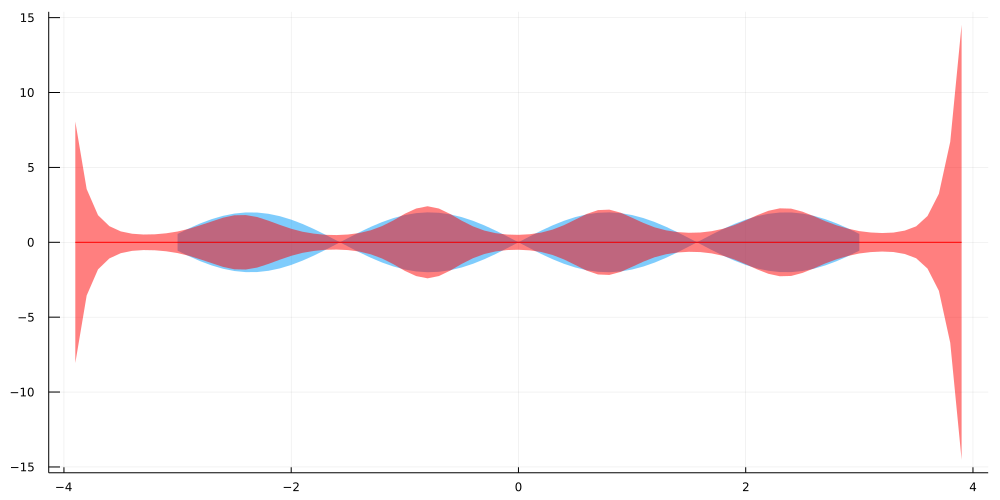

In [63]:
# Monte Carlo sampling from the posterior predictive distribution for y_star
mc_samples = [randn(size(Xline)[2]).*sqrt.((exp.(rand(p_f_star)))) for _ in 1:100000]
mc_sample_matrix = hcat(mc_samples...)

#posterior predictive mean is zero by our model definition
posterior_predictive_mean = zeros(size(Xline)[2])[:]

posterior_predictive_std = std(mc_sample_matrix,dims=2)[:]



#plot(Xline[:],posterior_predictive_mean,legend=:none,ribbon=(posterior_predictive_mean.-ci_90percent_lower, ci_90percent_upper.-posterior_predictive_mean), fmt = :png,size=(1000,500),
#color=:green)
plot(Xline_train,zeros(length(Xline_train));ribbon=(2 .* sin.(2 .*Xline_train)))
plot!(Xline[:],posterior_predictive_mean,legend=:none,ribbon=2 * posterior_predictive_std, fmt = :png,size=(1000,500), color=:red)
#scatter!(X[:],y[:],color=:red)

In order to see what happens for data that lies outside of the range of our training data, the evaluation was performed on the interval $[-3.9,3.9]$. As you can see, the posterior predictive covariance quickly increases when we are outside of the range of observed data. 

This is exactly what should happen under the influence of epistemic uncertainty. To some extent, a model can learn which functions describe the variance function of our training data well enough. On the other hand, the set of candiate functions that might equally well describe data outside our observations grows larger, the further we look outside the observation range. 

Put simple, the less similar our test data is to the training data, the more uncertain we should be about our predictions. This uncertainty is typically captured quite well by the variance and kurtosis of the posterior predictive distribution. 

This can also seen quite well by comparing the posterior predictive density for an X that lies in the center of observed data vs. the posterior predictive density for an X rather outside that range:

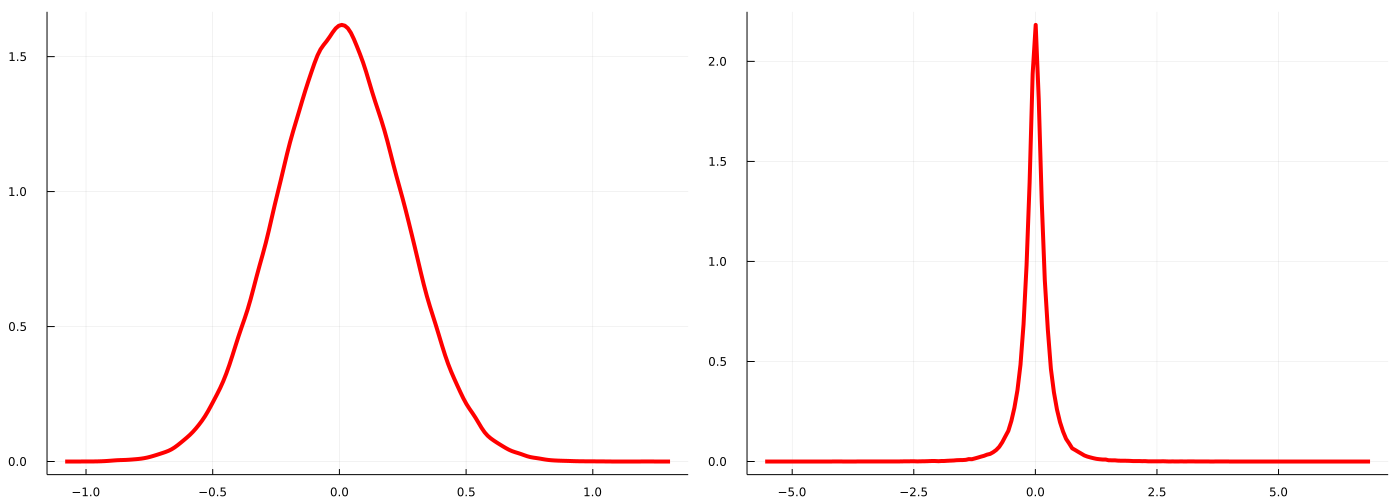

In [66]:
plot(density(mc_sample_matrix[findall(Xline[:].==0.)[1],:],legend=:none,color=:red,lw=4),density(mc_sample_matrix[findall(Xline[:].==-3.5)[1],:],legend=:none,color=:red,lw=4),
size=(1400,500),fmt=:png)

It is quite obvious that the posterior predictive density at -3.5 implies a much broader range of potential values for y than posterior predictive density at zero. Being able to quantify such uncertainty is probably one of the most intriguin features of Bayesian Machine Learning and I can highly recommend to dive deeper into this vast field. 

# Going further

Obviously, the example we used was only a toy dataset and doesn't yet prove anything about the real-world capabilities of the proposed model. If you are interested, feel free to use and modify the code and try the model on something more realistic. 

One potential application for such models would be financial time-series data which are quite well known to exhibit highly variable variance in periods of crisis. While GARCH models are often consider state-of-the-art here, a GP model might be an interesting alternative. Another possible improvement to the whole would be to allow the mean function to be also GP-distributed. 

A final word should be raised about scalability: Plain GP models as the one we discussed here are quite infamous for being infeasible for larger datasets. Luckily, a lot of smart people have developed methods to solve these issues, at least to some extent. In case you are interested in such approaches, you can find a really helpful overview in [these slides from the Gaussian Process Summer School 2019](http://gpss.cc/gpss19/slides/Dai2019.pdf).

And that's it for today. Thanks for reading this far and let me know in the comments if you have any questions or found any errors in this post.